# Practical Session 2

TP réalisé par Julien Dubourg et Victoire Bach

In [1]:
import numpy as np
from scipy.optimize import linprog
from forban import *
from forban.bandits import NormalBandit, Normal
from forban.sequentialg import SequentiAlg
from forban.utils import *
import matplotlib.pyplot as plt

# Structured Bandit

We study the classical multi-armed bandit problem specified by a set of real-valued
Gaussian distributions $ (\nu_a)_{a \in \mathcal{A}}$ with means $(\mu_a)_{a \in \mathcal{A}} \in \mathbb{R}^\mathcal{A}$ and unitary variances, where $\mathcal{A}$ is a finite set of arms. We denote $\mu_* = \max \{ \mu_a | a \in \mathcal{A} \}$.

At each time $t \geq 1$, an agent must choose an arm $a_t \in \mathcal{A}$, based only on
the past. A reward $X_t$ is drawn from the chosen distribution $\mu_{a_t}$ and observed by the agent. The goal of the agent is to maximize the expected sum of rewards received over time, or equivalently to minimize regret
with respect to the strategy constantly receiving the highest mean reward.

## Part 0 - Bandit environment, how to?

## Distributions - Arms

In [2]:
mean_1 = 0.
mean_2 = 1.
normal_1 = Normal(mean_1)
normal_2 = Normal(mean_2)
sample_1 = normal_1.sample()
sample_2 = normal_2.sample()
means = [mean_1, mean_2]
print(f"A sample from a normal distribution with mean {mean_1} and standard deviation 1 is {sample_1:.3f}")
print(f"A sample from a normal distribution with mean {mean_2} and standard deviation 1 is {sample_2:.3f}")

A sample from a normal distribution with mean 0.0 and standard deviation 1 is -2.933
A sample from a normal distribution with mean 1.0 and standard deviation 1 is 0.764


## Bandit instance

In [3]:
bandit_instance = NormalBandit([0.1, 0.2, 0.32, 0.24, 0.22])
print(f"A bandit instance is {bandit_instance}")

A bandit instance is Bandit([Normal (mean=0.100, std=1.000), Normal (mean=0.200, std=1.000), Normal (mean=0.320, std=1.000), Normal (mean=0.240, std=1.000), Normal (mean=0.220, std=1.000)])


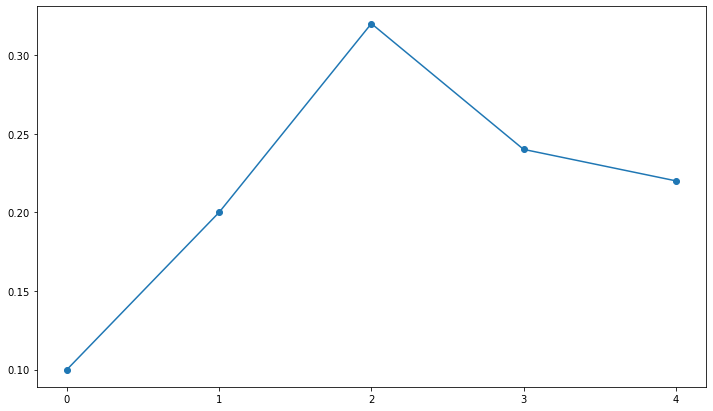

In [4]:
plot_bandit(bandit_instance)

## Sequential algorithms

In [5]:
# Constantly play the same arm
class Constant(SequentiAlg):
    def __init__(self, bandit, name="Constant", params={'init': 1, 'choice': 0 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.choice = params['choice']
        self.name = f"{self.name} (arm {self.choice})"
        assert self.choice < bandit.nbr_arms, f"'choice' ({self.choice}) should be one of\
the arms indices (<{bandit.nbr_arms})"
    
    def compute_indices(self):
        self.indices[self.choice] = 0
        
# Non-optimized Explore Then Commit strategy        
class Etc(SequentiAlg):
    def __init__(self, bandit, name="ETC", params={'init': 0, 'exploration': 200 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.exploration = params['exploration']
        
    def compute_indices(self):
        if self.time <= self.exploration:
            # probably faster computation is possible
            self.indices = np.random.rand(self.bandit.nbr_arms)
        else:
            self.indices = self.means
            
    def choose_an_arm(self):
        return randamax(self.indices)

In [6]:
# Set of means
means = [0.2, 0.5, 0., 0.05, 0.3, 0.4]
# Create a bandit problem
bandit = NormalBandit(means)
# Create sequential algorithms
seqalg1 = Constant(bandit) # Constantly play the same arm
seqalg2 = SequentiAlg(bandit, name="Random") # Sequentially choose an arm using a uniform distribution on the set of arms
seqalg3 = Constant(bandit, params = {'init': 1, 'choice': 3}) # Constantly play the same arm
seqalg4 = Etc(bandit) # Explore Then Commit strategy

In [7]:
print(seqalg4)

ETC algorithm - time step = 0
  Normal (mean=0.200, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.500, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.000, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.050, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.300, std=1.000) : est. mean = 0.000 - nbr. pulls = 0
  Normal (mean=0.400, std=1.000) : est. mean = 0.000 - nbr. pulls = 0



In [8]:
test_experiment = Experiment([seqalg1, seqalg2, seqalg3, seqalg4], bandit,
                             statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                             complexity=False)

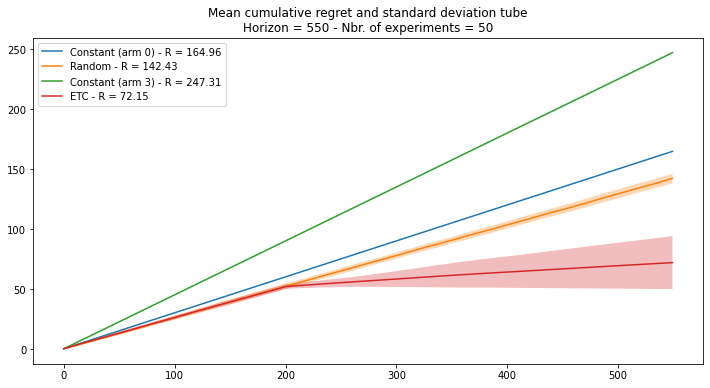

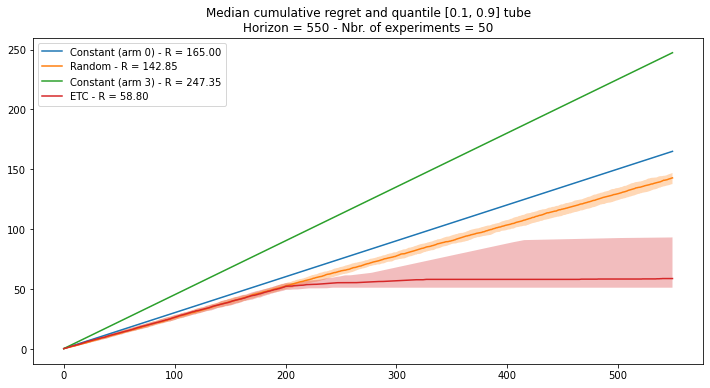

In [9]:
test_experiment.run(50, 550)
test_experiment.plot()

In [10]:
print(seqalg4)

ETC algorithm - time step = 550
  Normal (mean=0.200, std=1.000) : est. mean = 0.101 - nbr. pulls = 37
  Normal (mean=0.500, std=1.000) : est. mean = 0.504 - nbr. pulls = 386
  Normal (mean=0.000, std=1.000) : est. mean = 0.090 - nbr. pulls = 32
  Normal (mean=0.050, std=1.000) : est. mean = -0.089 - nbr. pulls = 32
  Normal (mean=0.300, std=1.000) : est. mean = 0.216 - nbr. pulls = 34
  Normal (mean=0.400, std=1.000) : est. mean = 0.216 - nbr. pulls = 29



## Part 1 - UCB algorithm

#### Question 1
Using the `SequentiAlg` class, implement the **UCB** algorithm.

#### Answer 1

In [11]:
class UCB(SequentiAlg):
    def __init__(self, bandit, name="UCB",
                 params={'init': np.inf, 'sigma':1, 'inv_delta': lambda t: (t+1)**2, 'alpha':2 }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.sigma = params['sigma']
        self.inv_delta = params['inv_delta']
        self.alpha = params['alpha']
    
    def compute_indices(self):
        if self.all_selected:
            # Exploration bonuses
            bonus = self.sigma * np.sqrt(self.alpha*np.log(self.inv_delta(self.time))/self.nbr_pulls)
            # Indexes
            self.indices = self.means + bonus
        else:
            for arm in np.where(self.nbr_pulls != 0)[0]:
                bonus = np.sqrt(self.alpha*np.log(self.inv_delta(self.time))/self.nbr_pulls[arm])
                self.indices[arm] = self.means[arm] + bonus
        
    def choose_an_arm(self):
        return randamax(self.indices)

#### Question 2
Using the `Experiment` class, run experiments on (at least) two bandit problems of your choice.

#### Answer 2

In [15]:
HORIZON = 500 # TODO
NBR_EXP = 50 # TODO

In [12]:
means = [0.3, 0.8 , 0.5] # TODO
bandit = NormalBandit(means)
ucb = UCB(bandit)
etc = Etc(bandit)
const = Constant(bandit)
seq = SequentiAlg(bandit, name="Random") 
algo_to_test = [ucb,etc,const,seq] # TODO
exp_ucb = Experiment(algo_to_test, bandit,
                     statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                     complexity=True)

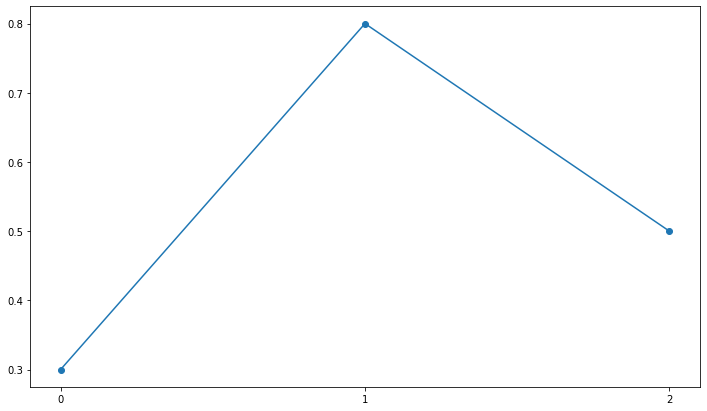

In [13]:
plot_bandit(bandit)

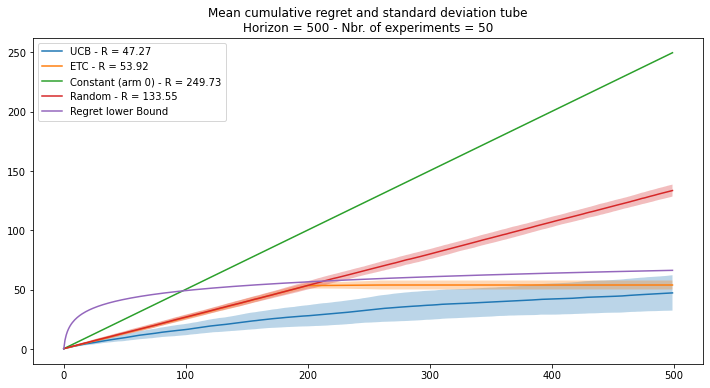

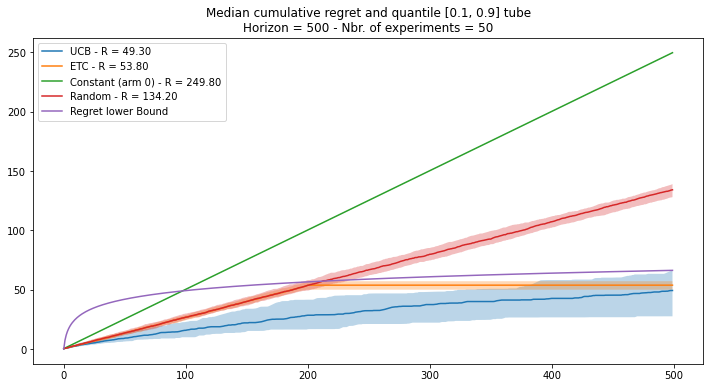

In [16]:
exp_ucb.run(NBR_EXP, HORIZON)
exp_ucb.plot()

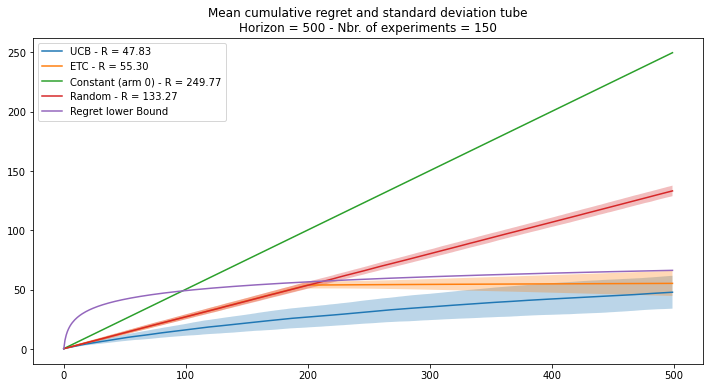

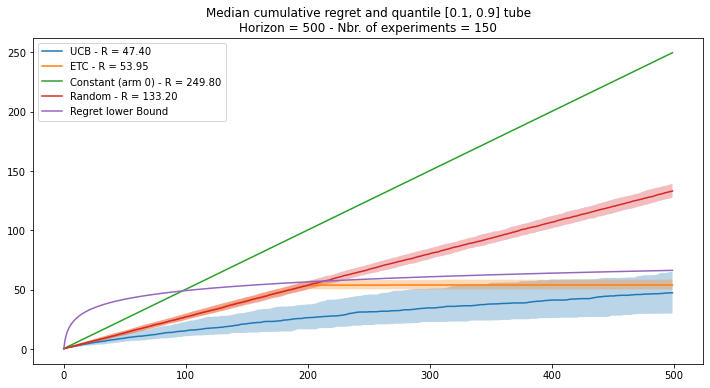

In [17]:
NBR_EXP = 150
exp_ucb.run(NBR_EXP, HORIZON)
exp_ucb.plot()

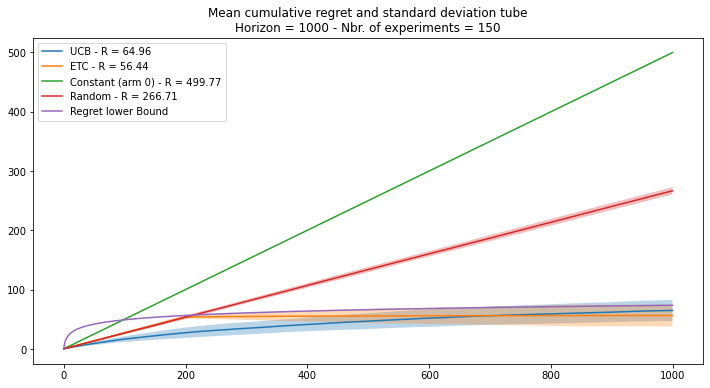

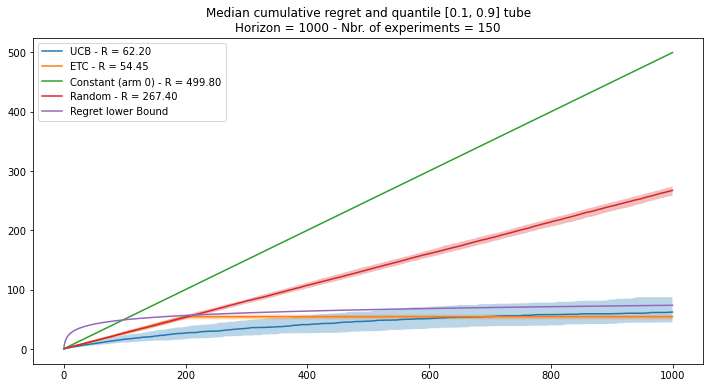

In [18]:
NBR_EXP = 150
HORIZON = 1000
exp_ucb.run(NBR_EXP, HORIZON)
exp_ucb.plot()

#### Question 3
Comment the plots.

#### Answer 3

Si on se place dans une optique de court terme, la stratégie UCB est plus performante que celle "Explore Then Commit" (ETC). Rapidement, la stratégie UCB trouve un compris entre exploration et exploitation donc c'est cohérent par rapport à la stratégie qui explore tout.

Dans une optique de plus long terme, le regret cumulé continue d'augmenter pour la stratégie UCB tandis que pour ETC le regret stagne: la stratégie UCB n'a pas encore trouvé le choix optimal de bras du bandit. Il faut donc encore optimiser cette stratégie.

## Part 2 - IMED algorithms

On a  Gaussian bandit instance, the *Lai and Robbins lower bound* tells us that the regret is **asymptotically** no smaller than 

$$\left(\sum_{a \in \mathcal{A}} \frac{\Delta_a}{\mathrm{KL}(\mu_a,\mu_*)}\right) \log(T),$$
where $\mathrm{KL}(\mu_a,\mu_*)$ is the KL-divergence between the Gaussian distribution of mean $\mu_a$ and the Gaussian distribution of mean $\mu_*$ (unitary variances). The constant in front of the $\log(T)$ may be called the **complexity** of the bandit problem.

For all arm $a \in \mathcal{A}$, for all time step  $t \geq 1$, the empirical mean of arm $a$ at time step $t$ is $$\hat \mu_a(t) = \dfrac{1}{N_a(t)} \sum\limits_{s = 1}^t \mathbb{1}_{\{a_s = a\}}X_s, \text{ if } N_a(t) > 0,\ 0 \text{ otherwise}, $$
where $N_a(t) = \sum\limits_{ s=1}^t \mathbb{1}_{\{ a_s = a\}}$ is the number of pulls of arm $a$ at time $t$. We write $\hat \mu_*(t) = \max\limits_{a \in \mathcal{A}}\hat\mu_a(t)$.

#### IMED strategy - Honda and Takemura (2011)

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the IMED index is defined as follows:
$$ I_a(t) = N_a(t)\,\mathrm{KL}\!\left(\hat\mu_a(t),\hat \mu_*(t)\right)+ \log\!\left(N_a(t)\right) \,. $$

This quantity can be seen as a transportation cost for “moving" a sub-optimal arm to an optimal one,
plus exploration terms (the logarithms of the numbers of pulls). When an optimal arm is considered,
the transportation cost is null and it remains only the exploration part. Note that, as stated in Honda
and Takemura (2011), $I_a(t)$ is an index in a weak sense since it cannot be determined only
by samples from the arm $a$ but also uses empirical means of current optimal arms.

IMED is the strategy that consists in pulling an arm with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \mathcal{A}}I_a(t)  \,.$$

#### Bonus Question
Derive the formula of the Kullback-Leibler divergences between two Gaussian distributions.

In [19]:
def complexity(bandit, kullback=klGaussian):
    suboptimal_arms = np.where(bandit.regrets != 0.)[0]
    term_1 = bandit.regrets[suboptimal_arms]
    term_2 = kullback(bandit.rewards[suboptimal_arms], bandit.best_reward)
    c = sum(term_1 / term_2)
    return c

#### Implementation of the IMED strategy

In [20]:
class IMED(SequentiAlg):
    def __init__(self, bandit, name="IMED", params={'init': -np.inf, 'kl':klGaussian}):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.kl = params['kl']
    
    def compute_indices(self):
        max_mean = np.max(self.means)
        if self.all_selected:
            self.indices = self.nbr_pulls*self.kl(self.means, max_mean) + np.log(self.nbr_pulls)
        else:
            for arm in np.where(self.nbr_pulls != 0)[0]:
                self.indices[arm] = self.nbr_pulls[arm]*self.kl(self.means[arm], max_mean) \
                + np.log(self.nbr_pulls[arm])

#### Experiment the IMED strategy

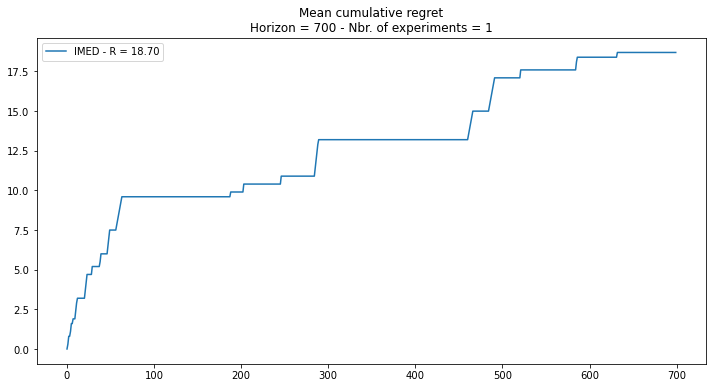

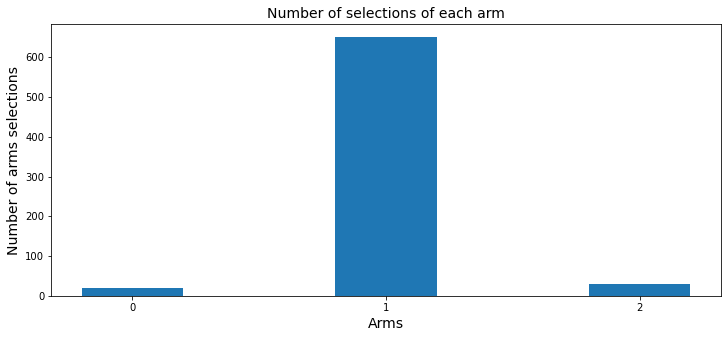

In [21]:
horizon = 700
agent = IMED(bandit)
experiment_imed = Experiment([agent], bandit,
                             statistics={'mean':True, 'std':False, 'quantile':False, 'pulls':False},
                             complexity=False)

experiment_imed.run(1, horizon)
experiment_imed.plot()
# Visualize results (on one run) 

# Histogram of the number of arms selections
plt.figure(figsize=(12,5))
plt.xlabel("Arms", fontsize=14)
plt.ylabel("Number of arms selections", fontsize=14)
plt.bar(range(bandit.nbr_arms), agent.nbr_pulls, width=0.4, tick_label=[str(i) for i in range(bandit.nbr_arms)])
plt.title("Number of selections of each arm", fontsize=14)
plt.show()

#### Compare strategies

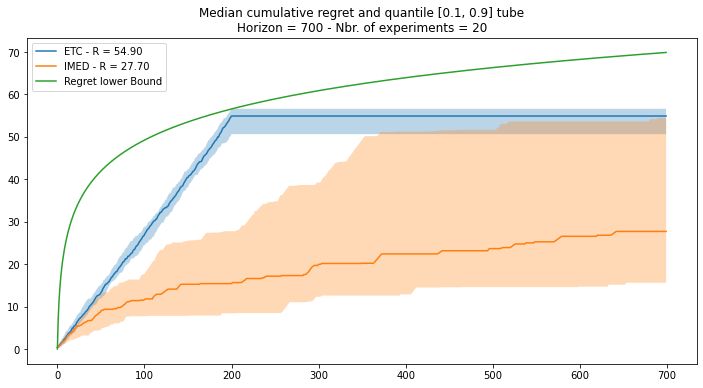

In [22]:
nbr_exp = 20
horizon = 700
etc = Etc(bandit) # Explore Then Commit strategy
imed = IMED(bandit) # IMED strategy
experiment = Experiment([etc, imed], bandit,
                        statistics={'mean':False, 'std':False, 'quantile':True, 'pulls':False},
                        complexity=True)
experiment.run(nbr_exp, horizon)
experiment.plot()

## Part 2 - Unimodal bandits

We assume that $\mathcal{A} = \left\{0, \dots, A-1\right\}, A \geq 1$, and $ \mu : \begin{cases}
	\mathcal{A}   &  \to  \mathbb{R} \\
	a  &\mapsto  \mu_a
	\end{cases} $ is unimodal. That is, there exists $ a_* \!\in\! \mathcal{A}$ such that $\mu_{[\![0,a_*]\!]} $ is increasing and $ \mu_{[\![ a_*, A]\!]} $ is  decreasing. It is further assumed that for each arm $a$,  $ \nu_{a} $ is a Gaussian distribution $ \mathcal{N}(\mu_a,1) $ , where $ \mu_a \in \mathbb{R} $ is the mean of the distribution $\nu_{a}$. We denote the structured set of Gaussian unimodal bandit distributions by 
	$$\mathcal{D}_{\text{unimodal}} = \bigg\{\nu = (\nu_a)_{a \in \mathcal{A}}:\  \forall a \!\in\! \mathcal{A},\ \nu_a \sim \mathcal{N}(\mu_a,1) \text{ with } \mu_a \!\in\! \mathbb{R}\text{ and }\mu \text{ is unimodal}\bigg\}\,.$$

On a  Gaussian unimodal bandit instance, the Lai and Robbins lower bound tells us that the regret is **asymptotically** no smaller than 

$$\left(\sum_{a \in \mathcal{V}_{a_*}} \frac{\Delta_a}{\mathrm{KL}(\mu_a,\mu_*)}\right) \log(T),$$
where $\mathcal{V}_{a_*} = \{a_* - 1, a_* + 1\}\cap\mathcal{A}$ and $\mathrm{KL}(\mu_a,\mu_*)$ is the KL-divergence between the Gaussian distribution of mean $\mu_a$ and the Gaussian distribution of mean $\mu_*$ (variances equal to $1$). The constant in front of the $\log(T)$ may be called the **unimodal complexity** of the bandit problem.

### 1) Computing regret lower bound for a unimodal bandit instance

#### Question 4
Write a function that computes the complexity of a unimodal Gaussian bandit instance.

#### Answer 4

In [24]:
def unimodalComplexity(bandit):
    a_star = np.argmax(bandit.means)
    mu_a_star = bandit.means[a_star]
    mu_sig = means[max(0, a_star - 1) : min(len(bandit.means), a_star + 2)]
    sig = 0
    for mu in mu_sig:
        s += (mu_a_star - mu)/klGaussian(mu, mu_a_star)
    return s
    

#### Question 5
Write a function that generates at random a unimodal Gaussian bandit instance.

#### Answer 5

In [48]:
def BanditUnimodal(nbr_arms, rewards=None, min_reward=0, max_reward=1):
    
    if rewards!=None:
        return NormalBandit(rewards)
    else:
        values = np.random.uniform(min_reward,max_reward,nbr_arms)
        max_position=np.random.randint(1,nbr_arms) #the max position shouldn't be first or last
    
        max_value = np.max(values)
        a_max = np.argmax(values)

        values = np.delete(values, a_max)
        values = np.concatenate(
            (np.sort(values[:max_position]),
             [max_value], 
             -np.sort(-values[max_position:])))

        bandit = NormalBandit(values)

        return bandit

The unimodal complexity of the generated bandit problem is 140.22080940698433


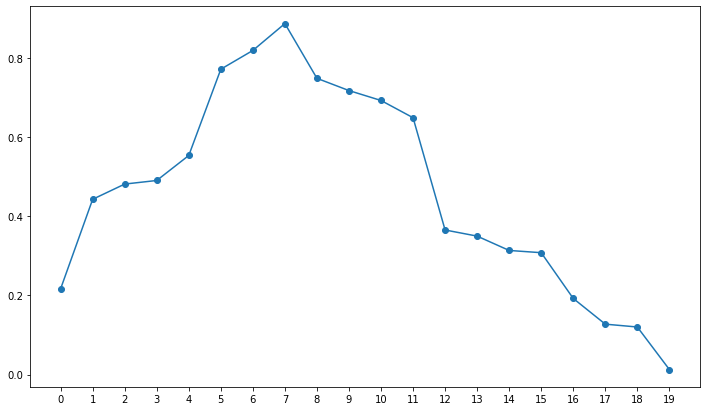

In [49]:
bandit = BanditUnimodal(20)
print(f"The unimodal complexity of the generated bandit problem is {bandit.complexity()}")
plot_bandit(bandit)

#### Question 6
On a unimodal Gaussian bandit instance $\nu $ of your choice, add the theoretical lower bound $t \mapsto C_{\text{unimodal}}(\nu) \log(t)$ where $C_{\text{unimodal}}(\nu)$ is the unimodal complexity of a unimodal bandit problem to the regret curve of IMED.

Add a plot with experiments of your choice using the previous algorithms.

#### Answer 6

The unimodal complexity of the generated bandit problem is 43.48571428571429


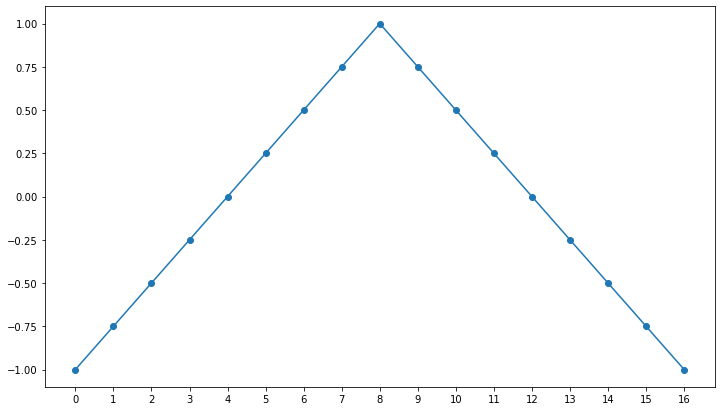

In [50]:
bandit = BanditUnimodal(17,[1-0.25*abs(8-a) for a in range(17)])
print(f"The unimodal complexity of the generated bandit problem is {bandit.complexity()}")
plot_bandit(bandit)

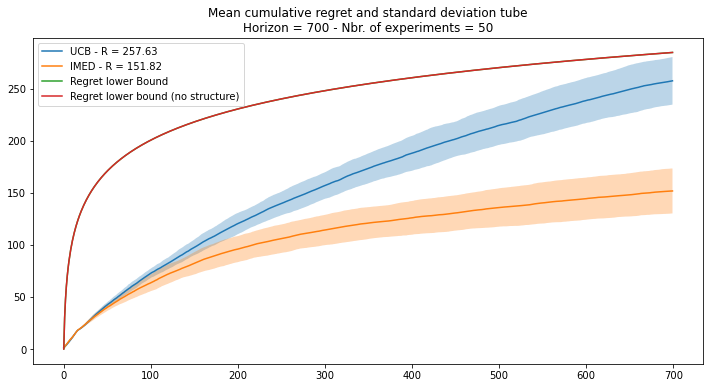

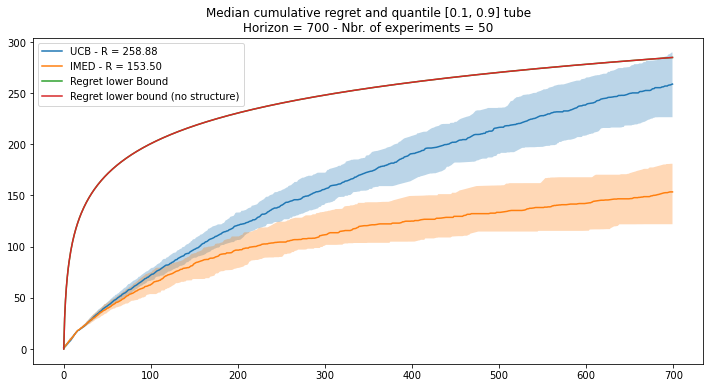

In [47]:
nbr_exp = 50 # TODO
horizon = 700 # TODO
ucb = UCB(bandit) # Explore Then Commit strategy
imed = IMED(bandit) # IMED strategy
algo_to_test = [ucb, imed] # TODO
experiment = Experiment(algo_to_test, bandit,
                        statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                        complexity=True)
experiment.run(nbr_exp, horizon)
experiment.plot(functions=[(lambda x: np.log(x+1)*complexity(bandit), "Regret lower bound (no structure)")])

### 2) IMED for Unimodal Bandit

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the IMED4UB index is defined as follows:
$$ I_a(t) = N_a(t)\,\mathrm{KL}\!\left(\hat\mu_a(t),\hat \mu_*(t)\right)+ \log\!\left(N_a(t)\right) \,. $$

IMED4UB is the strategy that consists in pulling an arm in the neighbourhood of the current optimal arm (also called leader arm, the one with the largest empirical mean) with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \mathcal{V}_{\hat a_*(t)}\cup \hat a_*(t)}I_a(t)  \,.$$

#### Question 7
Write a class that provides an IMED type strategy for unimodal bandit inspired from  the regret lower bound for unimodal structure.

Experiment like it was done in **part 1**. You can comment and add experiments of your choice.

#### Answer 7

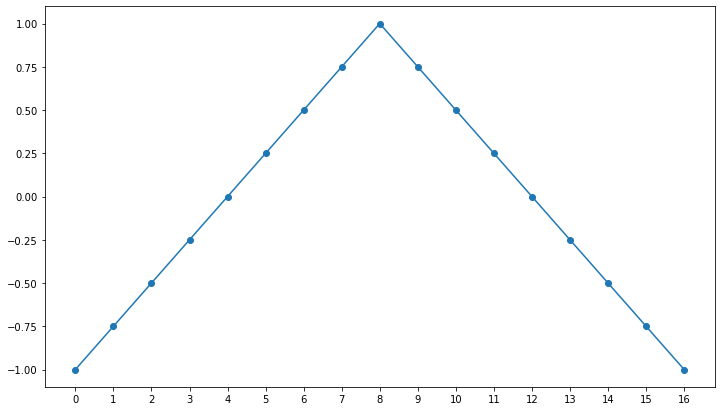

In [32]:
plot_bandit(bandit)

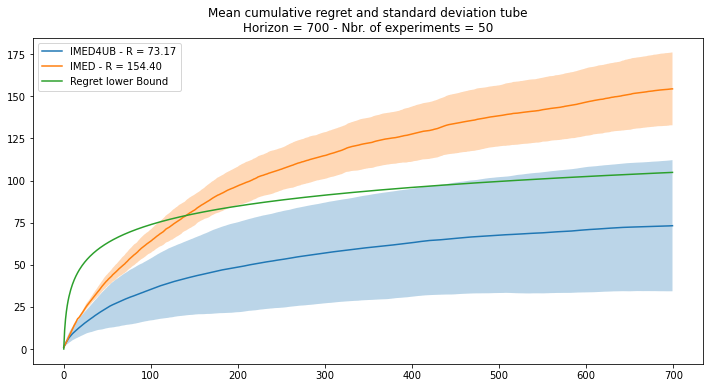

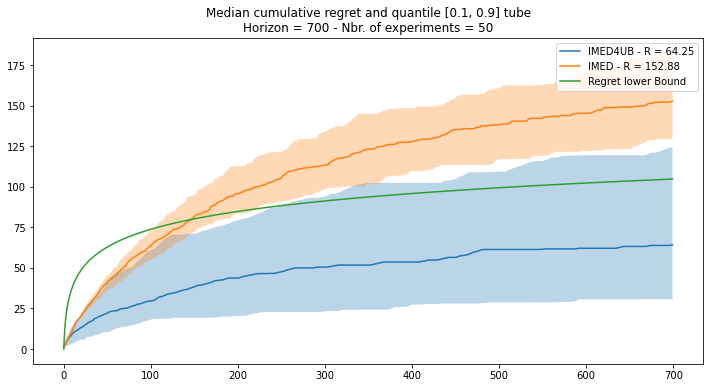

In [33]:
nbr_exp = 50 # TODO
horizon = 700 # TODO
imed4ub = IMED4UB(bandit) # TODO
imed = IMED(bandit) # IMED strategy
experiment = Experiment([imed4ub, imed], bandit,
                        statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                        complexity=True)
experiment.run(nbr_exp, horizon)
# experiment.plot(functions=[(lambda x: np.log(x+1)*complexity(bandit), "Regret lower bound (no structure)")])
experiment.plot()

## Part 3 - Lipschitz bandits

We assume that $\mathcal{A} = \left\{0, \dots, A-1\right\}, A \geq 1$, and $ \mu : \begin{cases}
	\mathcal{A}   &  \to  \mathbb{R} \\
	a  &\mapsto  \mu_a
	\end{cases} $ is $k$-Lipschitz, where is $k$ is assumed to be known. That is, for all $ a, a' \!\in\! \mathcal{A}$, $|\mu_a - \mu_{a'}| \leq k\!\times\! |a - a'|$. It is further assumed that for each arm $a$,  $ \nu_{a} $ is a Gaussian distribution $ \mathcal{N}(\mu_a,1) $ , where $ \mu_a \in \mathbb{R} $ is the mean of the distribution $\nu_{a}$. We denote the structured set of Gaussian $k$-Lipschitz bandit distributions by 
	$$\mathcal{D}_{k\text{-Lip}} = \bigg\{\nu = (\nu_a)_{a \in \mathcal{A}}:\  \forall a \!\in\! \mathcal{A},\ \nu_a \sim \mathcal{N}(\mu_a,1) \text{ with } \mu_a \!\in\! \mathbb{R}\text{ and }\mu \text{ is } k\text{-Lipschitz}\bigg\}\,.$$

On a Gaussian $k$-Lipschitz bandit instance, the lower bound specifies that the numbers of pulls satisfy **asymptotically** the following inequalities 

$$\forall a \in \mathcal{A}, \quad \sum_{a' \in \mathcal{V}_{a}} \mathrm{KL}\!\left(\mu_{a'},\,\mu_*\!-\!k|a \!-\! a'|\right)\,N_{a'}(T) \geq \log(T)\,,$$
where $\mathcal{V}_{a} = \big\{a'\!\in\!\mathcal{A}\!:  \mu_{a'}\!<\! \mu_*\!-\!k|a \!-\! a'|\big\}$ and $\mathrm{KL}(\mu,\mu')$ is the KL-divergence between the Gaussian distribution of mean $\mu$ and the Gaussian distribution of mean $\mu'$ (unitary variances). The constant $C_{k\text{-Lip}}(\nu)$ resulting from the following linear programming problem may be called the **Lipschitz complexity** of the bandit problem:
$$  C_{k\text{-Lip}}(\nu) =
 \min \bigg\{\sum\limits_{a \in \mathcal{A}} (\mu_*-\mu_a)\,n_{a}:\ n \in \mathbb{R}_+^{\mathcal{A}} \text{ s.t. } \forall a \in \mathcal{A},\sum_{a' \in \mathcal{V}_{a}} \mathrm{KL}\!\left(\mu_{a'},\,\mu_*\!-\!k|a \!-\! a'|\right)\,n_{a'} \geq 1\bigg\}\,. 
$$

### 1) Computing regret lower bound for a k-Lipschitz bandit instance

#### Question 8
Write a function that computes the complexity of a  $k$-Lipschitz bandit instance.

#### Answer 8

We aim to solve $\min_n \Delta^T n $ such that $\left ( KL(\mu_{a'}, \mu_* - k |a - a'|) \mathbb{1}_{a' \in \mathcal{V}_{a}} \right )_{a,a'} n \succcurlyeq 1$ which is a linear optimization problem with respect to $n$.

In [34]:
def lipschitzComplexity(bandit, k=0.26):
    max_mean = bandit.best_mean
    best_arm = bandit.best_arm
    
    c = bandit.regrets
    b = -np.ones(bandit.nbr_arms-1, float)
    
    delta_lip = max_mean-k*np.abs(np.arange(bandit.nbr_arms).reshape(1,-1)-np.arange(bandit.nbr_arms).reshape(-1,1))
    neighbors_mask = (delta_lip-bandit.rewards > 0).astype(int)
    
    A = klGaussian(bandit.rewards, delta_lip)*neighbors_mask
    A = -A[np.arange(bandit.nbr_arms)!=best_arm]
    
    res = linprog(c, A_ub=A, b_ub=b, bounds=(0, None))
    return res.fun

`neighbors_mask = (delta_lip-bandit.rewards > 0)` is a boolean array such that for all arm `a`, `neighbors_mask[a]` is a boolean list/array of size `bandit.nbr_arms` informing us about the neighbors $\mathcal{V}_a$ of the arm `a`. Thus, `neighbors_mask[a][a']` is `True` if $a' \in \mathcal{V}_a$ and `False` otherwise. Feel free to use this code when implementing IMED for Lipschitz bandit and pay attention to the inequalities (strict or no).

#### Question 9
Write a function that generates at random a Lipschitz Gaussian bandit instance.

#### Answer 9

In [35]:
def BanditLipschitz(nbr_arms, k, rewards=None, min_reward=-1, max_reward=1):
    if rewards == None:
        delta = max_reward - min_reward
        rewards = [min_reward + delta*np.random.rand()]
        for a in range(1, nbr_arms):
            rewards += [min(max(rewards[a-1]-k, min_reward) + min(2*k, delta)*np.random.rand(), max_reward)]
    assert nbr_arms == len(rewards)
    bandit_instance = NormalBandit(rewards, structure="Lipschitz", complexity=lipschitzComplexity)
    return bandit_instance

0.21832925327236752


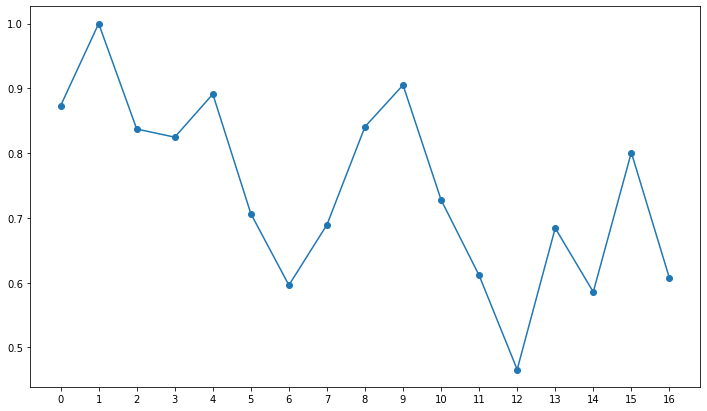

In [36]:
blip = BanditLipschitz(17, 0.25)
print(np.max(np.abs(blip.rewards[1:] - blip.rewards[:-1])))
plot_bandit(blip)

#### Question 10
On a $k$-Lipschitz Gaussian bandit instance $\nu $ of your choice, add the theoretical lower bound $t \mapsto C_{k-\text{Lip}}(\nu) \log(t)$ where $C_{k\text{-Lip}}(\nu)$ is the lipschitz complexity of a lipschitz bandit problem to the regret curve of IMED.

Add a plot with experiments of your choice using the previous algorithms (IMED and KLUCB+).

#### Answer 10

The following only is an example, please try to do an experiment of your own and comment it.

The lipschitz complexity of the generated bandit problem is 24.431508607096333


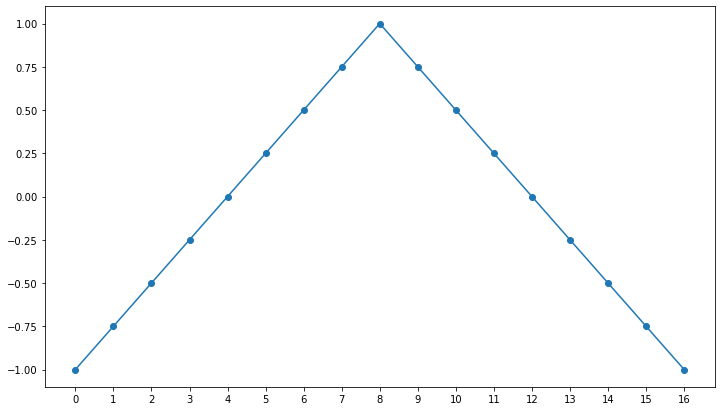

In [58]:
# Example, Do It Yourself ! :-)
bandit = BanditLipschitz(17, 0.25, [1-0.25*abs(8-a) for a in range(17)])
print(f"The lipschitz complexity of the generated bandit problem is {bandit.complexity()}")
plot_bandit(bandit)

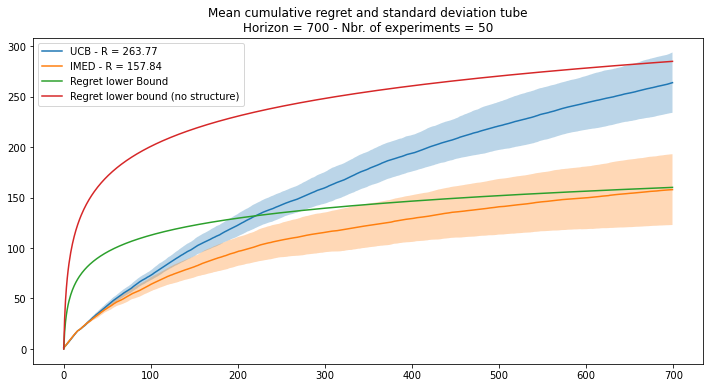

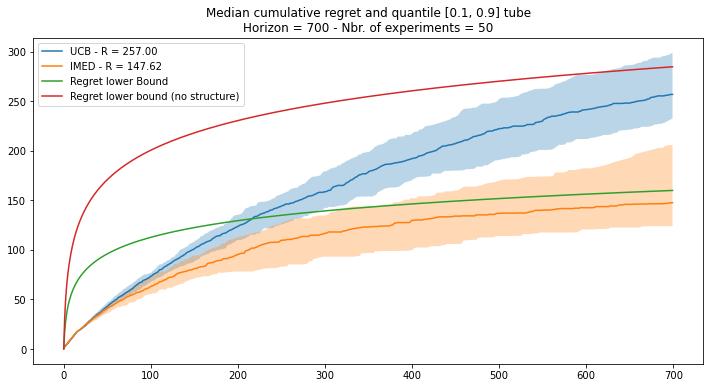

In [38]:
nbr_exp = 50
horizon = 700
ucb = UCB(bandit) # UCB
imed = IMED(bandit) # IMED strategy
experiment = Experiment([ucb, imed], bandit,
                        statistics={'mean':True, 'std':True, 'quantile':True, 'pulls':False},
                        complexity=True)
experiment.run(nbr_exp, horizon)
experiment.plot(functions=[(lambda x: np.log(x+1)*complexity(bandit), "Regret lower bound (no structure)")])

### 2) IMED for Lipschitz Bandit

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the IMED4LB index is defined as follows:
$$ I_a(t) = \sum\limits_{a ' \in \hat{\mathcal{V}}_{a}(t)}N_{a'}(t)\,\mathrm{KL}\!\left(\hat\mu_{a'}(t),\hat \mu_*(t) - k |a - a'|\right)+ \log\!\left(N_{a'}(t)\right) \,, $$
where $\hat{\mathcal{V}}_{a}(t) = \big\{a'\!\in\!\mathcal{A}\!:  \hat\mu_{a'}(t)\!\leq\! \hat\mu_*(t)\!-\!k|a \!-\! a'|\big\}$.

IMED4LB is the strategy that consists in pulling an arm with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \mathcal{V}_{\hat a_*(t)}}I_a(t)  \,.$$

#### Question 11
Write a class that provides an IMED type strategy for Lipschitz bandit inspired from the lower bounds on the number of pulls for Lipschitz structure.

Experiment like it was done in **part 1**. You can comment and add experiments of your choice.

#### Answer 11

In [ ]:
class IMED4LB(SequentiAlg):
    def __init__(self, bandit, name="IMED4LB", params={'init': -np.inf, 'kl':klGaussian,'k':0.26}):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.kl = params['kl']
        self.k=params["k"]
    
   # def compute_indices(self):
   #     max_mean = np.max(self.means)
   #     if self.all_selected:
    #        self.indices = self.nbr_pulls*self.kl(self.means, max_mean-k*abs()) + np.log(self.nbr_pulls)
    #    else:
     #       for arm in np.where(self.nbr_pulls != 0)[0]:
     #           self.indices[arm] = self.nbr_pulls[arm]*self.kl(self.means[arm], max_mean) \
      #          + np.log(self.nbr_pulls[arm])

## Part 4 - Linear bandits

Let us consider the discretisation $\mathcal{A} = \left\{0, \dots, A-1\right\}, A \geq 1$ of the space $ \mathcal{X} = \bigg\{x_a=\dfrac{a}{A}\ ,a\!\in\!\mathcal{A} \bigg\} \subset [0,1]$. Let us consider the parameter space $\Theta = \mathcal{B}(O,1)\subset\mathbb{R}^d$, $d = 2p+1$, $p\geq 1$, and the related function space $\mathcal{F}_{\Theta} = \bigg\{ f_\theta: x\in \mathcal{X} \mapsto \theta^{\text{T}}\phi(x)\ , \theta \in \Theta \bigg\}$, where $ \forall x\in\mathcal{X}, \phi(x) = \!\left(1, \cos(2\pi x),\sin(2\pi x),\dots,\cos(2\pi p x), \sin(2\pi p x)\right) $. It is further assumed that for all parameter $\theta\in\Theta$, for all arm $a\in\mathcal{A}$,  $ \nu_{a}(\theta) $ is a Gaussian distribution $ \mathcal{N}(\mu_a(\theta),1) $ , where $ \mu_a(\theta) = f_\theta(x_a) $ is the mean of the distribution $\nu_{a}(\theta)$. We denote the structured set of Linear bandit distributions by 
	$$\mathcal{D}_{\Theta} = \bigg\{\nu(\theta) = \left(\nu_a(\theta)\right)_{a \in \mathcal{A}}\ , \theta\in\Theta \bigg\}\,.$$

#### Question 12
Write a function that generates at random a Linear Gaussian bandit instance.

In [ ]:
def LinearGaussianBandit(nbr_arms, rewards=None, min_reward=0, max_reward=1):
    
    if rewards!=None:
        return NormalBandit(rewards)
    else:
        values = np.random.uniform(min_reward,max_reward,nbr_arms)
        max_position=np.random.randint(1,nbr_arms) #the max position shouldn't be first or last
    
        max_value = np.max(values)
        a_max = np.argmax(values)

        values = np.delete(values, a_max)
        values = np.concatenate(
            (np.sort(values[:max_position]),
             [max_value], 
             -np.sort(-values[max_position:])))

        bandit = NormalBandit(values)

        return bandit

### 1) The Linear UCB algorithm

#### Question 13
Implement the linear UCB algorithm: LinearUCB($\lambda=1$, $\delta= 0.05$ , $\sigma^2 = 1$).

### 2) The Linear IMED algorithm

For an arm $a \in \mathcal{A}$ and a time step $t\geq 1$, the LinearIMED index is defined as follows:
$$ I_a(t) = N_a^{\text{eff}}(t)\,\dfrac{\left(\max_{x \in \mathcal{X}}\hat f_{t,\lambda}(x)  - \hat f_{t,\lambda}(x_a)\right)^2}{2} +  \log\!\left(N_a^{\text{eff}}(t)\right) \,, $$
where $ \hat f_{t,\lambda} $ is the current estimate of $f$ and $N_a^{\text{eff}}(t) = \!\left( |\!| \phi(x_a) |\!|_{G_t^{-1}}^2 \right)^{-1}  $, the effective number of pull of arms $a$. $ G_t$ is the current Gramm matrix (used for the regression).


LinearIMED is the strategy that consists in pulling an arm with minimal index at each time step:
$$ a_{t+1} = \arg\!\min_{a \in \mathcal{A}}I_a(t)  \,.$$

#### Question 14
Write a class that provides an IMED type strategy for linear bandit inspired from the lower bounds on the number of pulls for Linear structure.

#### Question 15
Compare LinearUCB and LinearIMED.